# Semi-Supervised Sybil Detection on Gitcoin Grants

Source: https://hackmd.io/QCCJWZE0Ru27X_GRk6UKjQ

## Dependences

In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

time: 7.77 ms (started: 2021-04-08 12:56:37 -03:00)


In [2]:
# Library dependences
import cloudpickle
import holoviews as hv
import plotly.express as px
import networkx as nx
import pandas as pd
import numpy as np

# Local dependences
#from model_gitcoin.parts.utils import plot_contributions
from qf_research.functions import total_amount
from qf_research.functions import contributions_to_graph
# from qf_research.definitions import optimality_gap_per_grant
from qf_research.definitions import amount_per_grant

time: 3.38 s (started: 2021-04-08 12:56:38 -03:00)


## Machine Learning Pipeline

In [19]:
from pathlib import Path
import os

DATA_PATH = Path("../data/classified/")

sample_df = pd.read_csv(DATA_PATH / "sample_df.csv.xz", 
                        compression='xz')

nan_inds = pd.isnull(sample_df.is_sybil)
training_df = sample_df.loc[~nan_inds]
prediction_df = sample_df.loc[nan_inds].drop(columns=['is_sybil'])

training_df.head(3)

,sample_id,sample_feature_0,sample_feature_1,sample_feature_2,sample_feature_3,pattern_feature_0,sample_feature_4,sample_feature_5,amount_median,amount_std,contrib_count,eth_share,is_sybil
22,22,0,0,0,0,3,2.0,2.0,1.395557,0.000000,2,0.500000,True
37,37,14,4,0,0,1,-3319.0,6.0,95.000000,16.777435,29,0.004756,False
40,40,0,0,0,0,8,1.0,6.0,1.618501,0.645286,593,0.001686,True


time: 172 ms (started: 2021-04-08 12:59:09 -03:00)


### Training

In [8]:
from sklearn.model_selection import train_test_split

y_cols = {'is_sybil'}
X_cols = set(training_df.columns) - y_cols
X_cols -= {'sample_feature_0', 
           'sample_feature_1',
           'sample_feature_2', 
           'sample_feature_3'}

y = training_df.loc[:, y_cols].astype(bool)
X = training_df.loc[:, X_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

time: 427 ms (started: 2021-04-08 12:57:46 -03:00)


#### Decision Tree

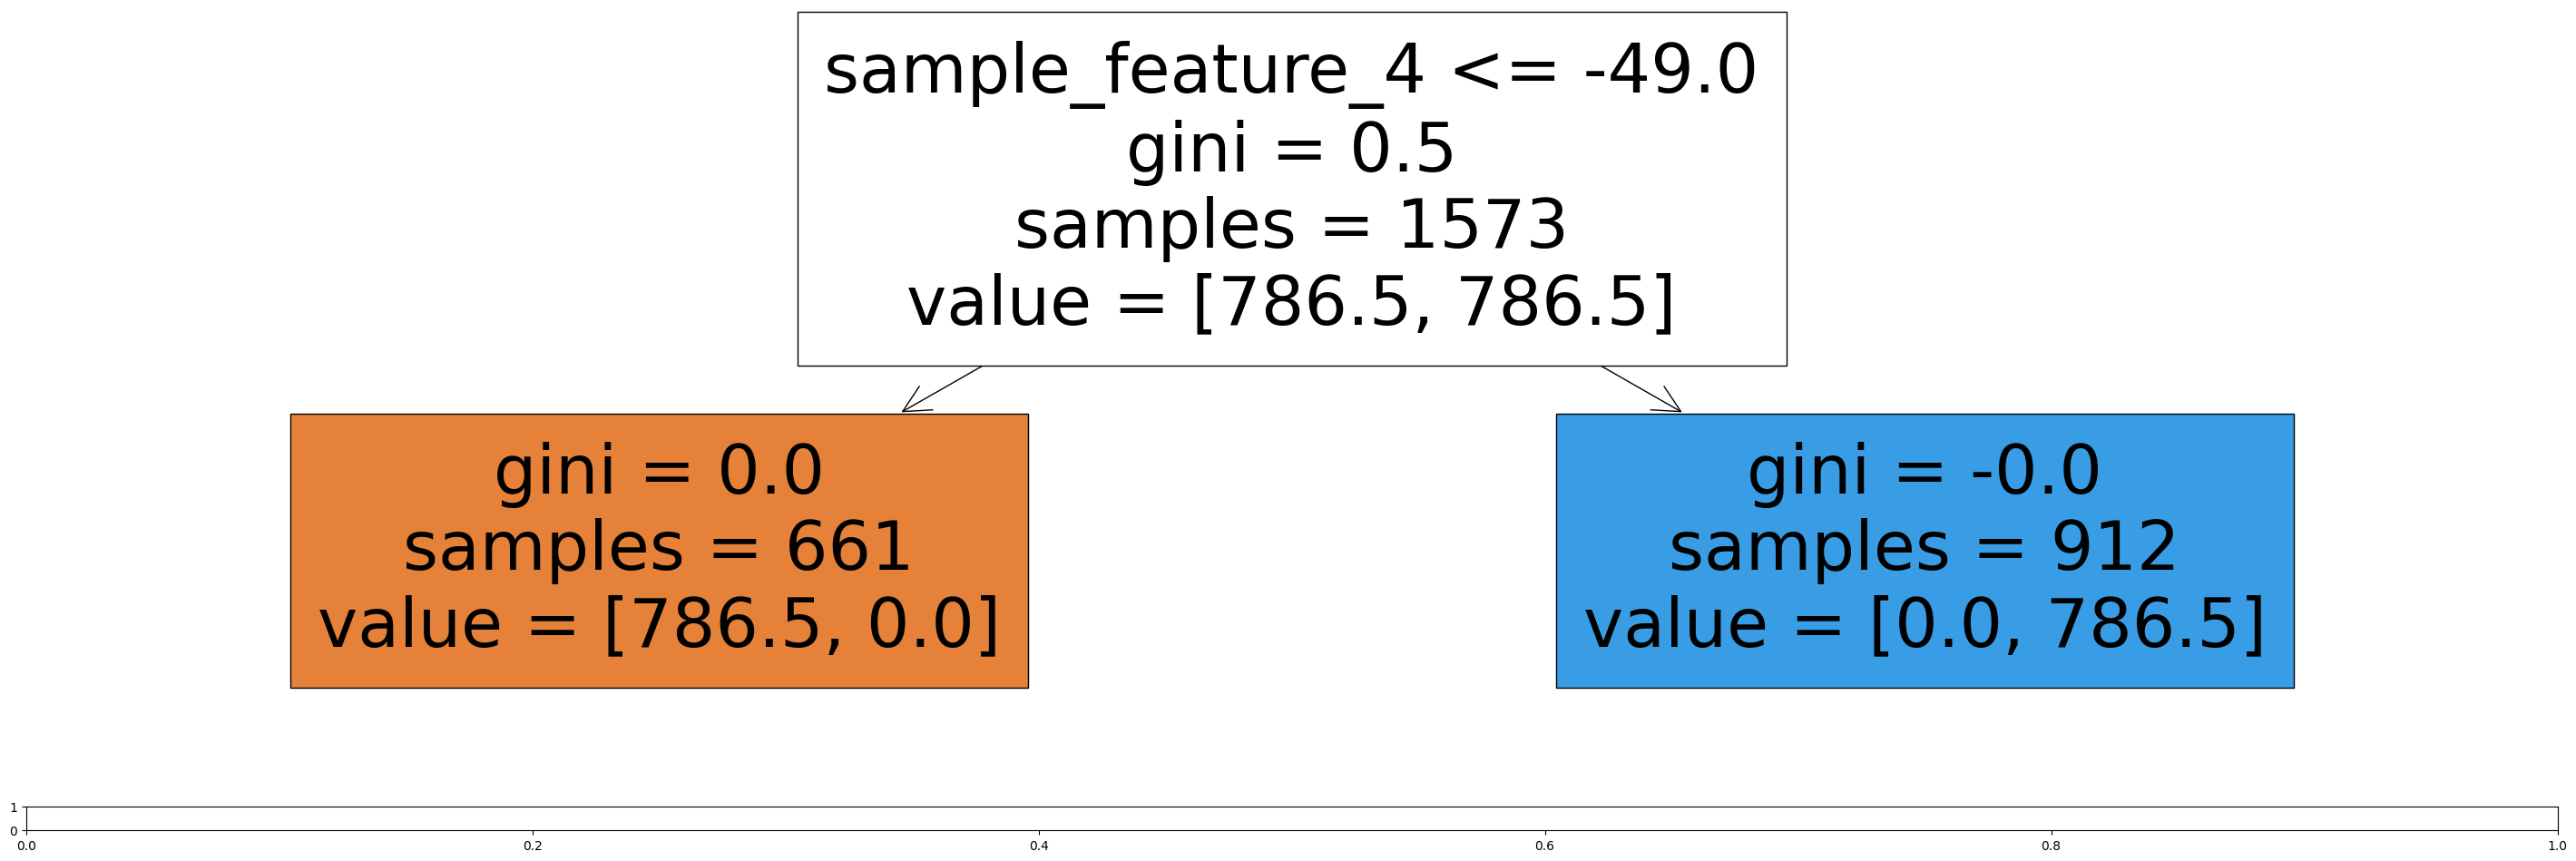

time: 1.77 s (started: 2021-04-08 12:57:48 -03:00)


In [9]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

clf = DecisionTreeClassifier(class_weight='balanced',
                                   max_depth=3, random_state=42)

clf.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=2,
                            figsize=(36, 12),
                            dpi=100,
                            gridspec_kw={'height_ratios': [3, 0.1]},                            )

tree.plot_tree(clf, 
               filled=True,
               feature_names=list(X_cols),
               ax=axes[0])
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score
rfc_cv_score = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
px.box(rfc_cv_score, title='CV score')

time: 1.87 s (started: 2021-04-08 12:57:50 -03:00)


#### Random Forest

<AxesSubplot:xlabel='features'>

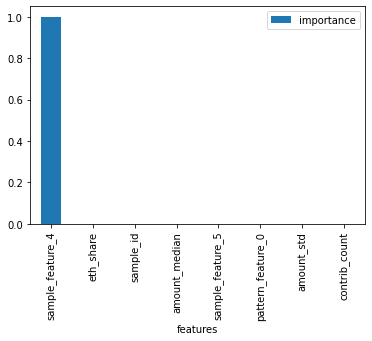

time: 724 ms (started: 2021-04-08 12:57:54 -03:00)


In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import seaborn as sns

rf = RandomForestRegressor()

rf = RandomForestRegressor()
rf.fit(X_train, np.ravel(y_train))
rf_df = (pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)),
                   columns=['features', 'importance'])
      .sort_values(by='importance', ascending=False)
      )

rf_df.set_index('features').plot(kind='bar')

In [12]:
from sklearn.model_selection import cross_val_score
rfc_cv_score = cross_val_score(rf, X, np.ravel(y), cv=10, scoring='roc_auc')
px.box(rfc_cv_score, title='CV score')

time: 5.68 s (started: 2021-04-08 12:57:55 -03:00)


<AxesSubplot:xlabel='features'>

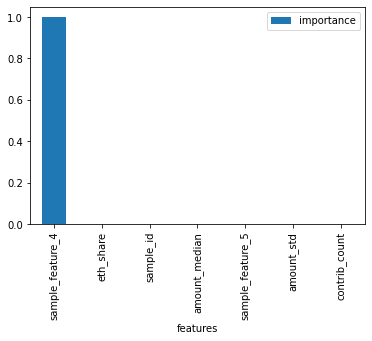

time: 1.2 s (started: 2021-04-08 12:58:01 -03:00)


In [13]:
drop_cols = {'pattern_feature_0'}
X2 = X_train.drop(columns=drop_cols)
rf_2 = RandomForestRegressor()
rf_2.fit(X2, np.ravel(y_train))
rf_df = (pd.DataFrame(list(zip(X2.columns, rf_2.feature_importances_)),
                   columns=['features', 'importance'])
      .sort_values(by='importance', ascending=False)
      )

rf_df.set_index('features').plot(kind='bar')

In [14]:
from sklearn.model_selection import cross_val_score
rfc_cv_score = cross_val_score(rf_2, X, np.ravel(y), cv=10, scoring='roc_auc')
px.box(rfc_cv_score, title='CV score')

time: 5.27 s (started: 2021-04-08 12:58:02 -03:00)



### Inference

In [20]:
X_pred = prediction_df
y_pred = rf.predict(X_pred)

ValueError: X has 12 features, but DecisionTreeRegressor is expecting 8 features as input.

In [78]:
y_flag = (y_pred > 0.5)

time: 49.1 ms (started: 2021-03-25 20:01:06 -03:00)


### Summary Statistics

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, (rf.predict(X_train) > 0.5))

1.0

time: 44.2 ms (started: 2021-03-25 20:01:07 -03:00)


In [80]:
total_sybil_users = len(output_df.query('is_sybil == True'))
total_users = len(output_df)

print(f"Total sybil users: {total_sybil_users :.0f}")
print(f"Sybil share: {total_sybil_users / total_users :.1%}")
print(f"Total users: {total_users :.0f}")

Total sybil users: 1626
Sybil share: 16.6%
Total users: 9766
time: 30.4 ms (started: 2021-03-25 20:01:07 -03:00)


In [81]:
sybil_users = set(output_df.query('is_sybil == True').index)

sybil_df = df[df.handle.isin(sybil_users)]

sybil_contribs = len(sybil_df)
sybil_contrib_fraction = sybil_contribs / len(df)

print(f"Total sybil contributions: {sybil_contribs} ({sybil_contrib_fraction :.1%})")

Total sybil contributions: 21364 (15.2%)
time: 50.1 ms (started: 2021-03-25 20:01:09 -03:00)


In [82]:
sybil_amount = sybil_df.amount.sum()
sybil_amount_fraction = sybil_amount / df.amount.sum()
print(f"Total sybil amount: {sybil_amount} ({sybil_amount_fraction :.1%})")

Total sybil amount: 83213.10729018433 (6.1%)
time: 27.5 ms (started: 2021-03-25 20:01:10 -03:00)


In [99]:
flagged_df = (inference_df.copy()
                .assign(flag_type='Prediction')
                .assign(is_sybil=y_flag)
                .assign(ml_score=y_pred))


labeled_df = (training_df.copy()
                          .assign(flag_type='Heuristic')
                          .assign(ml_score=training_df.is_sybil.astype(float))
              )

cols = {'flag_type', 'is_sybil', 'ml_score'}
output_df = pd.concat([flagged_df, labeled_df]).loc[:, cols]

time: 112 ms (started: 2021-03-25 20:04:28 -03:00)


In [104]:
px.histogram(output_df.reset_index(),
             'ml_score',
             facet_col='is_sybil',
             facet_row='flag_type',
             log_y=True,
             title='User count segmented by flagging / ml_score / type')

time: 146 ms (started: 2021-03-25 20:05:11 -03:00)


## Export results

In [105]:
output_df.to_csv(DATA_PATH / "ml-prediction.csv")

time: 51 ms (started: 2021-03-25 20:06:18 -03:00)


In [ ]:
# Export to google sheets